<a href="https://colab.research.google.com/github/jairomartinezgiraldo/CNN/blob/main/CNNVIERNES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import os
from google.colab import files
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [35]:
# 1 de Kaggle en nuestro entorno.

# Importar librerías necesarias
import os
from google.colab import files


# Descargar el dataset de Yoga desde Kaggle
!kaggle datasets download -d tr1gg3rtrash/yoga-posture-dataset

# Descomprimir el archivo descargado
import zipfile
with zipfile.ZipFile('yoga-posture-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/yoga_dataset')

print("Dataset descargado y extraído exitosamente.")


Dataset URL: https://www.kaggle.com/datasets/tr1gg3rtrash/yoga-posture-dataset
License(s): CC0-1.0
yoga-posture-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset descargado y extraído exitosamente.


Total de clases: 47
Clases encontradas: ['Ardha Chandrasana', 'Dhanurasana', 'Pincha Mayurasana', 'Trikonasana', 'Eka Pada Rajakapotasana', 'Virabhadrasana Two', 'Sivasana', 'Utkatasana', 'Garudasana', 'Baddha Konasana', 'Salamba Bhujangasana', 'Halasana', 'Utthita Hasta Padangusthasana', 'Bakasana', 'Virabhadrasana Three', 'Navasana', 'Urdhva Dhanurasana', 'Setu Bandha Sarvangasana', 'Uttanasana', 'Padmasana', 'Adho Mukha Svanasana', 'Utthita Parsvakonasana', 'Ardha Pincha Mayurasana', 'Ashta Chandrasana', 'Urdhva Mukha Svsnssana', 'Camatkarasana', 'Malasana', 'Paschimottanasana', 'Parsvottanasana', 'Ustrasana', 'Balasana', 'Anjaneyasana', 'Vasisthasana', 'Ardha Navasana', 'Adho Mukha Vrksasana', 'Hanumanasana', 'Ardha Matsyendrasana', 'Vrksasana', 'Upavistha Konasana', 'Supta Kapotasana', 'Phalakasana', 'Virabhadrasana One', 'Salamba Sarvangasana', 'Marjaryasana', 'Bitilasana', 'Parsva Virabhadrasana', 'Alanasana']


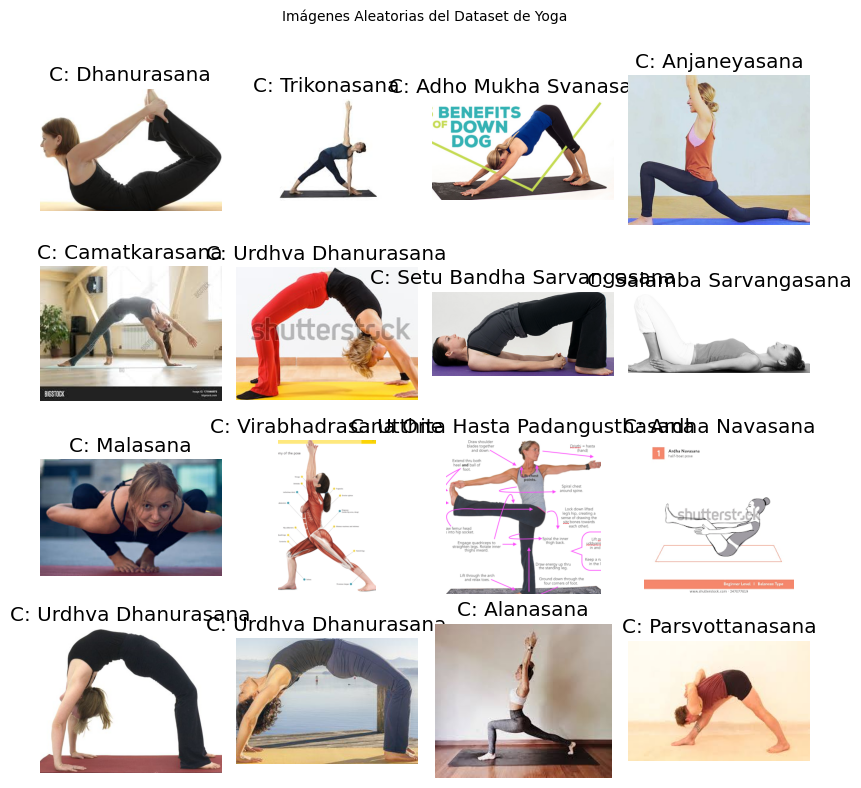

In [42]:
# Paso 2: Preparar el Conjunto de Datos

# Primero, definimos dónde está nuestro conjunto de datos
base_dir = '/content/yoga_dataset'

# Revisamos las clases dentro del dataset
import os
subfolders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print(f"Total de clases: {len(subfolders)}")
print("Clases encontradas:", subfolders)

# Mostramos algunas imágenes del conjunto de datos
# Esto nos ayuda a visualizar las imágenes y a familiarizarnos con ellas.
import matplotlib.pyplot as plt
import cv2
import numpy as np

fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.suptitle('Imágenes Aleatorias del Dataset de Yoga', fontsize=10)

for ax in axes.flatten():
    chosen_folder = np.random.choice(subfolders)
    subfolder_path = os.path.join(base_dir, chosen_folder)
    img_name = np.random.choice(os.listdir(subfolder_path))
    img_path = os.path.join(subfolder_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"C: {chosen_folder}")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Paso 3: Configuración de Generadores de Datos con Aumento de Datos
Para entrenar nuestra red de manera eficiente y mejorar su capacidad de generalización, usaremos Data Augmentation o aumento de datos. Esta técnica permite crear variaciones de las imágenes originales aplicando transformaciones como rotaciones, cambios de tamaño y espejado. De esta forma, la red "ve" más datos y puede aprender mejor.

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224, 224)

# Data Augmentation agresivo para generar más variabilidad en poses similares
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Dividir el dataset en 80% entrenamiento y 20% validación
)

# Generador de datos para entrenamiento y validación
train_generator = train_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',  # Clasificación multiclase
    subset='training',
    color_mode='rgb'
)

val_generator = train_datagen.flow_from_directory(
    '/content/yoga_dataset',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='rgb'
)

# Crear el generador de datos de prueba
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    '/content/yoga_test_dataset',  # Asegúrate de colocar la ruta correcta del conjunto de prueba
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='categorical',
    color_mode='rgb',  # Forzar carga en RGB
    shuffle=False  # Para mantener el orden de las clases
)


Found 2227 images belonging to 47 classes.
Found 529 images belonging to 47 classes.


Paso 4: Cargar una Red Preentrenada (Transfer Learning)
Aquí viene la parte interesante: Transfer Learning. Utilizaremos una red llamada ResNet50, que ya ha sido entrenada en millones de imágenes (de ImageNet). Esto significa que ResNet50 ya ha aprendido muchas características útiles para reconocer objetos. Nosotros aprovecharemos su "experiencia" y añadiremos nuestras propias capas finales para que pueda clasificar las posturas de yoga.

Nota: En este primer paso, no vamos a ajustar todas las capas; solo entrenaremos las capas que agregamos al final. Esto se llama "congelar" el modelo base.

In [44]:
# Cargar el modelo base MobileNetV2 preentrenado
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelar el modelo base para el primer entrenamiento

# Construir las capas adicionales para la clasificación
x = base_model.output
x = layers.Flatten()(x)  # Utilizar Flatten para conservar toda la información espacial
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(47, activation='softmax')(x)  # 47 clases de poses de yoga

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo con una tasa de aprendizaje inicial
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento inicial (solo las capas añadidas)
history_aug = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15  # Suficientes épocas para observar convergencia en Transfer Learning
)


predictions = model.predict(test_generator, batch_size=128)  # Realizamos la predicción
print("Reporte de Clasificación - Transfer Learning:")
print(classification_report(test_generator.classes, predictions.argmax(axis=1), target_names=test_generator.class_indices.keys()))

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/70 ━━━━━━━━━━━━━━━━━━━━ 22s 401ms/step - accuracy: 0.0723 - loss: 15.0710

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


70/70 ━━━━━━━━━━━━━━━━━━━━ 52s 595ms/step - accuracy: 0.1579 - loss: 15.0040 - val_accuracy: 0.3062 - val_loss: 10.9256
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 513ms/step - accuracy: 0.4454 - loss: 9.0234 - val_accuracy: 0.3384 - val_loss: 8.2003
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 510ms/step - accuracy: 0.5055 - loss: 7.0600 - val_accuracy: 0.2836 - val_loss: 8.5508
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 512ms/step - accuracy: 0.4771 - loss: 6.9293 - val_accuracy: 0.3384 - val_loss: 7.6652
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 512ms/step - accuracy: 0.5055 - loss: 6.5613 - val_accuracy: 0.4026 - val_loss: 6.8906
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 507ms/step - accuracy: 0.5255 - loss: 6.3004 - val_accuracy: 0.3138 - val_loss: 8.0318
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 509ms/step - accuracy: 0.5238 - loss: 6.1578 - val_accuracy: 0.4310 - val_loss: 6.4166
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 513ms/step - accuracy: 0.4909 - loss: 6.1116 - val_accuracy: 0.4

paso 5: Evaluación y Graficación de Métricas del Transfer Learning
Una vez completado el primer entrenamiento, evaluaremos las métricas de precisión y pérdida para ver cómo ha aprendido el modelo hasta ahora.

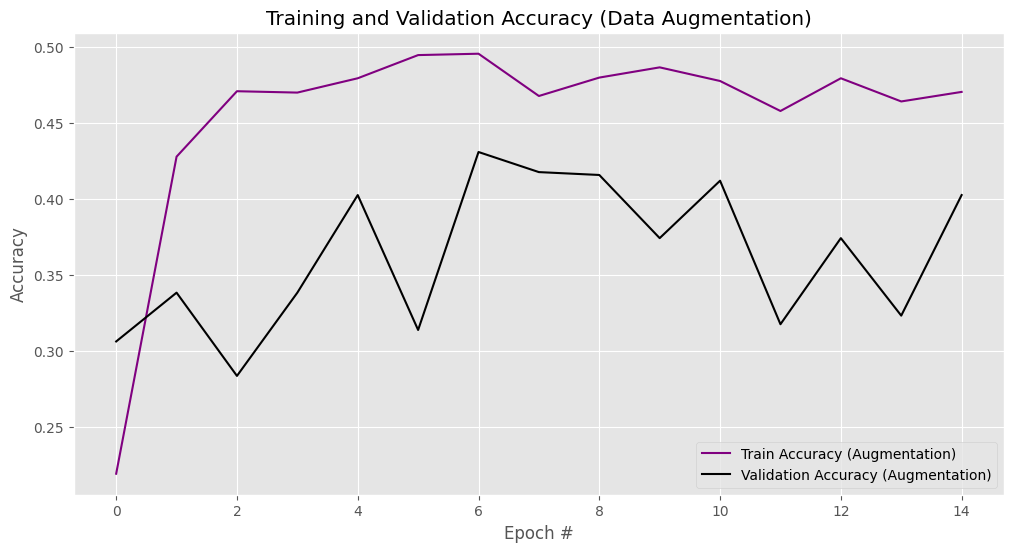

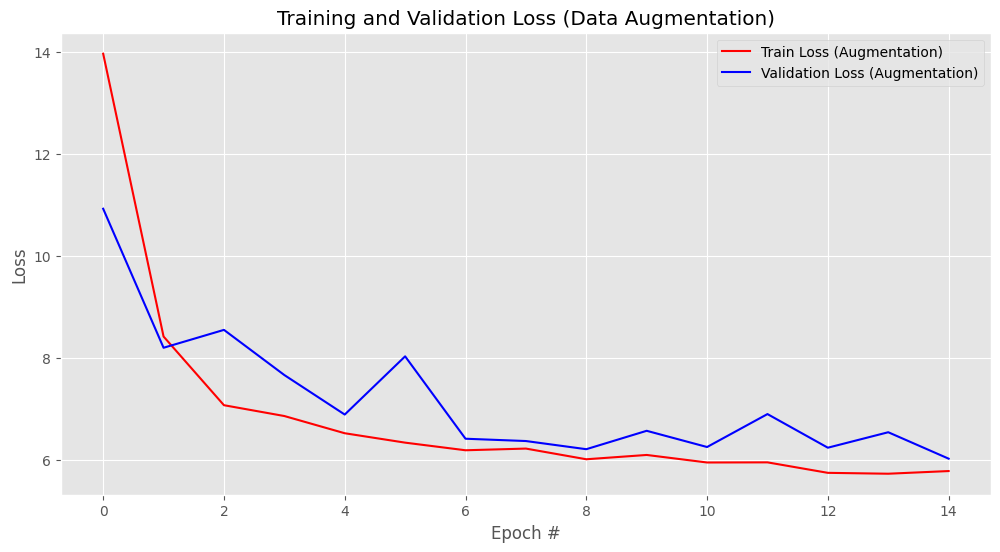

In [45]:
# Graficar Accuracy de entrenamiento y validación de Data Augmentation
plt.figure(figsize=(12, 6))
plt.plot(history_aug.history["accuracy"], label="Train Accuracy (Augmentation)", color='purple')
plt.plot(history_aug.history["val_accuracy"], label="Validation Accuracy (Augmentation)", color='black')
plt.title("Training and Validation Accuracy (Data Augmentation)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Graficar Loss de entrenamiento y validación de Data Augmentation
plt.figure(figsize=(12, 6))
plt.plot(history_aug.history["loss"], label="Train Loss (Augmentation)", color='red')
plt.plot(history_aug.history["val_loss"], label="Validation Loss (Augmentation)", color='blue')
plt.title("Training and Validation Loss (Data Augmentation)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()




Paso 6: Fine-Tuning del Modelo
Ahora vamos a realizar Fine-Tuning. Descongelaremos algunas capas de ResNet50 para que el modelo pueda ajustar mejor las características de alto nivel para nuestro conjunto de datos. Esto permite una especialización más profunda, pero hay que hacerlo con cuidado para evitar sobreajuste.

In [46]:
# Descongelar las últimas capas de MobileNetV2 para Fine-Tuning
base_model.trainable = True
fine_tune_at = 100  # Descongelar capas a partir de la capa 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compilar el modelo con una tasa de aprendizaje más baja
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenamiento con Fine-Tuning
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10  # Nuevas épocas para el ajuste fino
)

predictions = model.predict(test_generator, batch_size=128)
print("Reporte de Clasificación - Fine-Tuning:")
print(classification_report(test_generator.classes, predictions.argmax(axis=1), target_names=test_generator.class_indices.keys()))



Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 71s 685ms/step - accuracy: 0.4235 - loss: 5.5978 - val_accuracy: 0.3932 - val_loss: 5.1972
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 514ms/step - accuracy: 0.6150 - loss: 4.1374 - val_accuracy: 0.4405 - val_loss: 4.4562
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 512ms/step - accuracy: 0.6945 - loss: 3.3837 - val_accuracy: 0.5614 - val_loss: 3.7161
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 512ms/step - accuracy: 0.7402 - loss: 2.8947 - val_accuracy: 0.5274 - val_loss: 3.6760
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 515ms/step - accuracy: 0.7704 - loss: 2.5248 - val_accuracy: 0.5898 - val_loss: 3.1703
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 513ms/step - accuracy: 0.8257 - loss: 2.1727 - val_accuracy: 0.5879 - val_loss: 2.9529
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 512ms/step - accuracy: 0.8417 - loss: 1.9325 - val_accuracy: 0.6200 - val_loss: 2.5906
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 39s 512ms/step - accuracy: 0.8553 - loss: 1.7318 - val_accu

Paso 7: Evaluación y Graficación de Métricas con Fine-Tuning

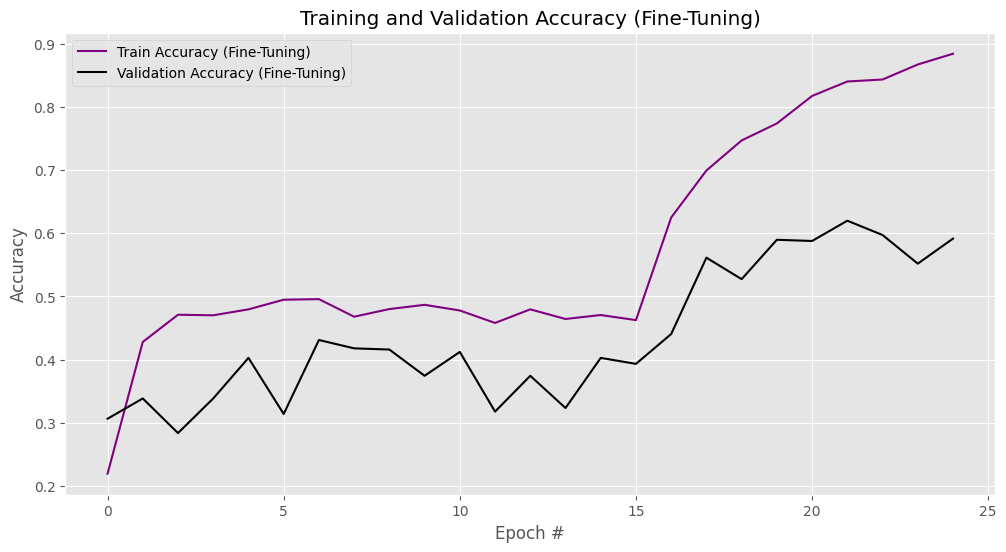

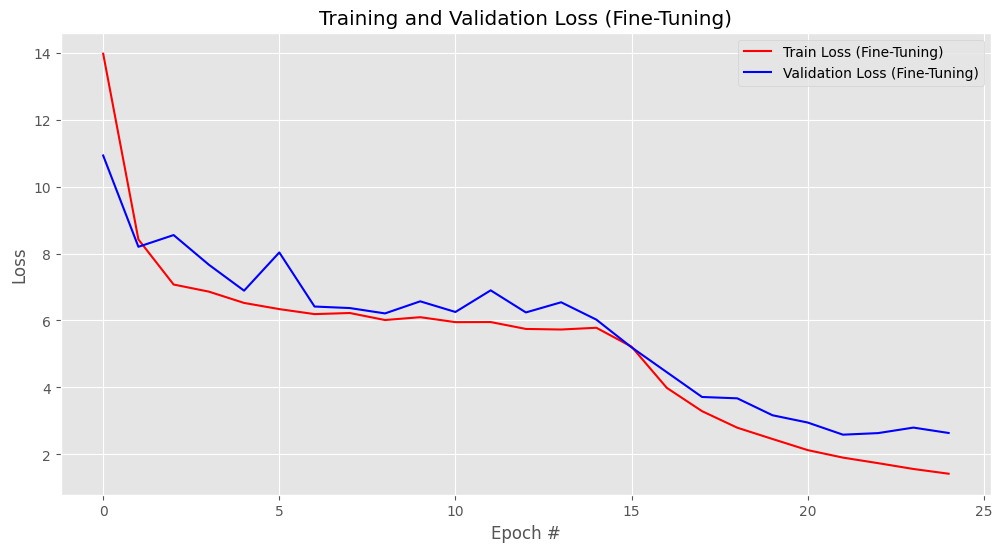

In [47]:
# Graficar Accuracy de entrenamiento y validación de Fine-Tuning


acc = history_aug.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_aug.history['val_accuracy'] + history_fine.history['val_accuracy']
plt.figure(figsize=(12, 6))
plt.plot(range(len(acc)), acc, label='Train Accuracy (Fine-Tuning)', color='purple')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy (Fine-Tuning)', color='black')
plt.title("Training and Validation Accuracy (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

# Graficar Loss de entrenamiento y validación de Fine-Tuning
loss = history_aug.history['loss'] + history_fine.history['loss']
val_loss = history_aug.history['val_loss'] + history_fine.history['val_loss']
plt.figure(figsize=(12, 6))
plt.plot(range(len(loss)), loss, label='Train Loss (Fine-Tuning)', color='red')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss (Fine-Tuning)', color='blue')
plt.title("Training and Validation Loss (Fine-Tuning)")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()